# LSI31003 Machine Learning in Molecular Biology Example for Random Forest

In [1]:
from setup import *
%matplotlib inline

In [2]:
#need to install some modules first so execute this cell
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn

In [3]:
from scipy.stats import *

In [4]:
#Some extra packages that are useful in this assignment
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn import datasets
from scipy.stats import gaussian_kde

##  Introduction <a id='section1'></a>

We use the same data set of somatic mutations as in assignments 1 and 2 from ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer. Nature"](https://www.nature.com/articles/s41586-020-1943-3).

In [5]:
## ploting 96 mutational channels
col_set = ['#0343df','#000000','#e50000','#929591','#3f9b0b','#ff81c0']
col_list = []
for i in range (len(col_set)):
    col_list += [col_set[i]] * 16

def plot_mutationchannels(sig, name=""):
    sns.set(rc={"figure.figsize":(11,2.5)})
    sns.set(style="whitegrid", color_codes=True)

    plt.bar(sig.index, sig, width = 0.5, color = col_list)
    plt.xticks(rotation=90, size = 7, weight='bold')
    plt.title (name, size = 12, weight='bold')
    plt.tight_layout()
    plt.show()

In [6]:
somaticMutations = pd.read_csv ("./data/MutSigCancer/WGS_PCAWG.96.csv")
somaticMutations = somaticMutations.set_index (somaticMutations['Mutation type'] + "_" + somaticMutations['Trinucleotide'])

In [7]:
somaticMutations.shape

(96, 2782)

In [8]:
somaticMutations.head()

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
C>A_ACA,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
C>A_ACC,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137
C>A_ACG,C>A,ACG,25,13,13,29,8,31,12,15,...,12,29,14,19,51,13,52,14,49,32
C>A_ACT,C>A,ACT,154,70,73,126,31,119,41,122,...,82,213,66,68,271,68,281,80,202,116
C>A_CCA,C>A,CCA,215,63,71,129,30,190,54,133,...,119,188,67,89,307,69,339,204,194,127


# Classifying cancer types

We can classify cancer types the following way using sklearn's `RandomForestClassifier` :

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [10]:
# Here is an example of how to get the various cancer types
cancer_types = np.array([ s.split(":")[0].split("-")[1] for s in somaticMutations.columns[2:] ])

In [11]:
pd.unique(cancer_types)

array(['AdenoCA', 'TCC', 'Benign', 'Epith', 'Osteosarc', 'DCIS',
       'LobularCA', 'GBM', 'Medullo', 'Oligo', 'PiloAstro', 'SCC',
       'ChRCC', 'RCC', 'HCC', 'BNHL', 'CLL', 'AML', 'MDS', 'MPN',
       'Endocrine', 'Melanoma', 'Leiomyo', 'Liposarc'], dtype=object)

In [12]:
# Then we split our data into training and testing sets
# Note that for the input matrix : columns are the features, rows are the samples
X_train, X_test, y_train, y_test = train_test_split(somaticMutations.iloc[:, 2:].T, cancer_types)

In [13]:
# Finally we create a RandomForestClassifier object, which we first train using fit()
model = RandomForestClassifier().fit(X_train, y_train)

# Then we use it to predict data, which we then assess
model.score(X_test, y_test)

0.781294964028777

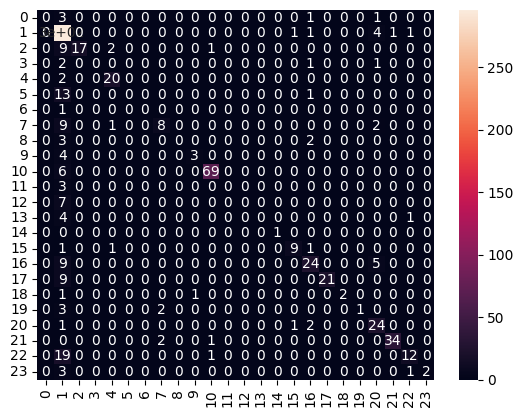

In [14]:
ax = sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot = True);

## Specific case for Melanoma

In [15]:
model = RandomForestClassifier().fit(X_train, y_train == "Melanoma")
model.score(X_test, y_test == "Melanoma")

0.9870503597122302

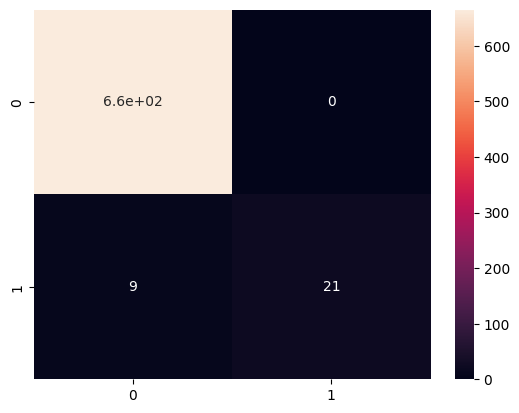

In [16]:
sns.heatmap(confusion_matrix(y_test == "Melanoma", model.predict(X_test)), annot = True);